**Autor: Mariana Chaves**
 
**Date: July 2022**

In this notebook we train diferent deep models to classify movie characters according to their gender based on their dialogues. 
That is, each sample contains all utterances on the character.

**This notebook has mostly didactic purposes.** We explain each step to train the model. In the notebook ```deep_models.ipynb``` you can find a more compact version of this code, and you can see more results related to the cornell corpus and many other combinations of models. 

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import gensim
import time
import pickle
from sklearn.model_selection import train_test_split

In [ ]:
# Path for saving results
path_to_models = 'results/models/'

# Epochs
epochs = 20

# Load data

We use the Cornell corpus with some preprocessing steps applied in Schofield, A., & Mehr, L. (2016). Gender-Distinguishing Features in Film Dialogue. Proceedings of the Fifth Workshop on Computational Linguistics for Literature, 32–39. https://doi.org/10.18653/v1/W16-0204. 

See ```cornell_corpus_preprocessing.ipynb``` for the code related to the preprocessing.

We use the data at character level. That is, each sample corresponds to all dialogues of a character.

In [ ]:
%cd ..

/content/drive/Othercomputers/My Laptop/Documents/UCA DSAI/Internship 2/Code/text-models


In [ ]:
data = pd.read_csv('datasets/cornell_corpus/cornell_prepro_characters.csv')
data

,Unnamed: 0,characterID,movieID,character_name,gender,movie_title,movie_year,movieGroup,text_with_punctuation,text
0,0,u0,m0,BIANCA,F,10 things i hate about you,1999,1,They do not! I hope so. Let's go. Okay you're ...,They do not I hope so Lets go Okay youre gonna...
1,1,u100,m6,AMY,F,8mm,1999,1,She died in her sleep three days ago. It was i...,She died in her sleep three days ago It was in...
2,2,u1001,m65,PETE,M,from dusk till dawn,1996,5,Six-fifty. Knock yourself out. That's all that...,Sixfifty Knock yourself out Thats all thats be...
3,3,u1007,m66,BLONDELL,F,g.i. jane,1997,1,Wow Uh don't see it. There's no signature. But...,Wow Uh dont see it Theres no signature But han...
4,4,u1008,m66,C.O.,M,g.i. jane,1997,1,"Of course, but there's more Uh, V.I.P. securit...",Of course but theres more Uh VIP security arra...
...,...,...,...,...,...,...,...,...,...,...
2399,2399,u983,m64,ALICE,F,friday the 13th,2009,3,Maybe we should wait for Mr. Christy. The kill...,Maybe we should wait for Mr Christy The killer...
2400,2400,u985,m64,BILL,M,friday the 13th,2009,3,It's over twenty miles to the crossroads. Stev...,Its over twenty miles to the crossroads Stevel...
2401,2401,u989,m64,MARCIE,F,friday the 13th,2009,3,Gotta pee. You're lying on my bladder. Like wa...,Gotta pee Youre lying on my bladder Like waves...
2402,2402,u993,m64,STEVE,M,friday the 13th,2009,3,I've got to go to town and pick up the trailer...,Ive got to go to town and pick up the trailer ...


We load our word2vec model just to extract its vocabulary.

In [ ]:
# Load word2vec trained model
w2v = gensim.models.KeyedVectors.load("results/cornell_prepro.wordvectors", mmap='r')

# word2vec vocabulary
w2v_vocabulary = list(w2v.vocab.keys())
print('Words in the vocabulary:',len(w2v_vocabulary))

Words in the vocabulary: 11270


In [ ]:
# Keep only the words that are in the vocabulary

# Sentences to lists of words
docs = [d.lower().split() for d in data['text']]

# Keep only the words that are in the w2v vocabulary (These were the words that appeared 5 times or more times)
docs = [[word for word in doc if word in w2v_vocabulary] for doc in docs]

# Join the list of strings into sentences
docs = [' '.join(doc) for doc in docs]
docs[0:3]

['they do not i hope so lets go okay youre gonna need to learn how to lie im kidding you know how sometimes you just become this and you dont know how to quit like my fear of wearing what good stuff me this endless blonde im like boring myself do you listen to this crap then says if you go any lighter youre gonna look like an extra on but well no i was tons you know hi who knows all ive ever heard her say is that shed dip before dating a guy that smokes lesbian no i found a picture of in one of her drawers so im pretty sure shes not i really really really wanna go but i cant not unless my sister goes deep conditioner every two days and i never ever use a without the youre sweet i counted on you to help my cause you and that thug are obviously failing arent we ever going on our date where how is our little find the wench a date plan forget french i dont want to know how to say that though i want to know useful things like where the good stores are how much does champagne cost stuff like

We use classic train, validation, test splitting.

In [ ]:
# Train, validation, test split
train_split = 0.7
val_split = 0.2
test_split = 1 - train_split - val_split

X = docs
# y = np.array((data['gender'] == 'F').astype('int'))
y = list((data['gender'] == 'F').astype('int'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 32, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_split/(train_split + val_split), random_state = 32, stratify = y_train) 

print('Samples in train: ', len(X_train))
print('Samples in val:', len(X_val))
print('Samples in test:', len(X_test))

Samples in train:  1682
Samples in val: 481
Samples in test: 241


In [ ]:
# Split was done keeping the balance in the datasets

print('Percent of women characters in train:', sum(y_train) / len(y_train))
print('Percent of women characters in val:', sum(y_train) / len(y_train))
print('Percent of women characters in test:', sum(y_train) / len(y_train))

Percent of women characters in train: 0.5
Percent of women characters in val: 0.5
Percent of women characters in test: 0.5


# Text vectorizer. 

We can set the vocabulary in this layer. Then this layer encodes the text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`)

In [ ]:
# VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(vocabulary = w2v_vocabulary)

# Note that the text vectization layer builds it's vocabulary taking into consideration the unknown tokens: [UNK]
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', 'they', ..., 'delbruck', 'inga', 'steen'],
      dtype='<U16')

In [ ]:
# Example of the encoding
encoded_example = encoder(X_train[0]).numpy()
encoded_example

array([    5,   281,   243,    99,  5266,  1144,   550,   166,     4,
        2498,  4745,  5557,  1097,  1208,  5557,     5,    13,    99,
         764,   182,     5,   654,  1005,    99,  1302,   749,    30,
        5444,     5,    27,    21,     5,   732,   132,    30,  1299,
         425,    52,   365,    73,    99,   382,    32,    30,   131,
         108,     5,  2376,  1698,   259,   632,   760,    14,  5557,
         737,    79,   802,  5557,    18,   110,    14,    73,  1226,
        5446,   324,   378,    20,    26,  2622,   130,    73,    35,
         581,     5,   204,    20,   192,     5,   275,    99,    80,
          11,    73,   474,   102,    34,     3,    20,   228,   249,
           3,    99,   212,   259,    20,  2559,     5,   132,   252,
        2369,   209,    56,    23,   229,    14,   313,    37,   134,
           5,   140,   273,   174,   152,    14,   378,  7620,    67,
         144,  1048,    20,   342,   130,    73,  1130,     5,   384,
         820,    20,

# Bidirectional LSTMs

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

We use Bidirectional RNNs. 

The `tf.keras.layers.Bidirectional` wrapper can be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.


The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking. 

The following models follow the same structure. They vary in their sizes. For instance, the size of the embedding, the size of the hidden state in the LSTM and the number of neurons in the dense layer.

## Model 1

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_name = 'textvectorizer_bidirectional_dense64'

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 308s 6s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 265s 5s/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 3/20
53/53 [==============================] - 257s 5s/step - loss: 0.6910 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5010
Epoch 4/20
53/53 [==============================] - 256s 5s/step - loss: 0.6889 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5010
Epoch 5/20
53/53 [==============================] - 255s 5s/step - loss: 0.6830 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.5010
Epoch 6/20
53/53 [==============================] - 251s 5s/step - loss: 0.6474 - accuracy: 0.5803 - val_loss: 0.6406 - val_accuracy: 0.6466
Epoch 7/20
53/53 [==============================] - 250s 5s/step - loss: 0.6070 - accuracy: 0.6795 - val_loss: 0.6604 - val_accuracy: 0.5260
Epoch 8/20
53

In [ ]:
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

8/8 [==============================] - 8s 711ms/step - loss: 0.6335 - accuracy: 0.6722
Test Loss: 0.6334512829780579
Test Accuracy: 0.6721991896629333


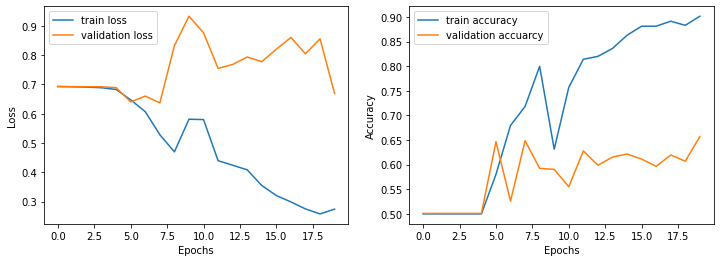

In [ ]:
pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 2

In [ ]:
model_name = 'textvectorizer_embedding256_bidirectional_dense128'

# Define architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 739s 14s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 712s 13s/step - loss: 0.6903 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5010
Epoch 3/20
53/53 [==============================] - 695s 13s/step - loss: 0.6857 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.5010
Epoch 4/20
53/53 [==============================] - 697s 13s/step - loss: 0.6636 - accuracy: 0.5155 - val_loss: 0.6724 - val_accuracy: 0.5031
Epoch 5/20
53/53 [==============================] - 707s 13s/step - loss: 0.5606 - accuracy: 0.6570 - val_loss: 0.6513 - val_accuracy: 0.6029
Epoch 6/20
53/53 [==============================] - 716s 14s/step - loss: 0.3689 - accuracy: 0.8306 - val_loss: 0.7607 - val_accuracy: 0.6133
Epoch 7/20
53/53 [==============================] - 757s 14s/step - loss: 0.1953 - accuracy: 0.9435 - val_loss: 0.7944 - val_accuracy: 0.6299
Epoch 

8/8 [==============================] - 3s 103ms/step - loss: 0.6076 - accuracy: 0.6515
Test Loss: 0.6076307892799377
Test Accuracy: 0.6514523029327393


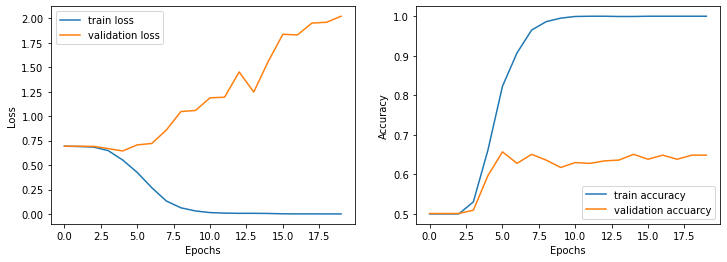

In [ ]:
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 3

In [ ]:
model_name = 'textvectorizer_embedding512_bidirectional256_dense128'

# Define architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 31s 408ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 19s 369ms/step - loss: 0.6871 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 3/20
53/53 [==============================] - 19s 366ms/step - loss: 0.6662 - accuracy: 0.5107 - val_loss: 0.6774 - val_accuracy: 0.5010
Epoch 4/20
53/53 [==============================] - 18s 348ms/step - loss: 0.5771 - accuracy: 0.5797 - val_loss: 0.6793 - val_accuracy: 0.5301
Epoch 5/20
53/53 [==============================] - 18s 348ms/step - loss: 0.4178 - accuracy: 0.7895 - val_loss: 0.6844 - val_accuracy: 0.6029
Epoch 6/20
53/53 [==============================] - 19s 346ms/step - loss: 0.2377 - accuracy: 0.9298 - val_loss: 0.7842 - val_accuracy: 0.6071
Epoch 7/20
53/53 [==============================] - 18s 346ms/step - loss: 0.0996 - accuracy: 0.9715 - val_loss: 0.8621 - val_accuracy: 0.5842

8/8 [==============================] - 4s 132ms/step - loss: 0.6654 - accuracy: 0.4979
Test Loss: 0.6653618216514587
Test Accuracy: 0.4979253113269806


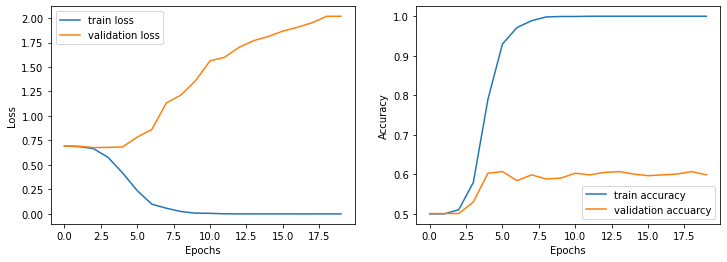

In [ ]:
# Evaluate on test
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot loss and accuracy
pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Simple LSTMs

These models use LSTMs instead of BLSTMs. 

## Text vectorizer + embedding + LSTM + Dense

In [ ]:
model_name = 'textvectorizer_embedding128_LSTM64_dense64'

# Define architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 12s 153ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 6s 114ms/step - loss: 0.6921 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/20
53/53 [==============================] - 6s 119ms/step - loss: 0.6906 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 4/20
53/53 [==============================] - 6s 122ms/step - loss: 0.6875 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5010
Epoch 5/20
53/53 [==============================] - 7s 123ms/step - loss: 0.6732 - accuracy: 0.5083 - val_loss: 0.6812 - val_accuracy: 0.5052
Epoch 6/20
53/53 [==============================] - 6s 116ms/step - loss: 0.6187 - accuracy: 0.6284 - val_loss: 0.6608 - val_accuracy: 0.5738
Epoch 7/20
53/53 [==============================] - 6s 117ms/step - loss: 0.5151 - accuracy: 0.7776 - val_loss: 0.6600 - val_accuracy: 0.5696
Epoch

8/8 [==============================] - 2s 57ms/step - loss: 0.6336 - accuracy: 0.6224
Test Loss: 0.6336387395858765
Test Accuracy: 0.6224066615104675


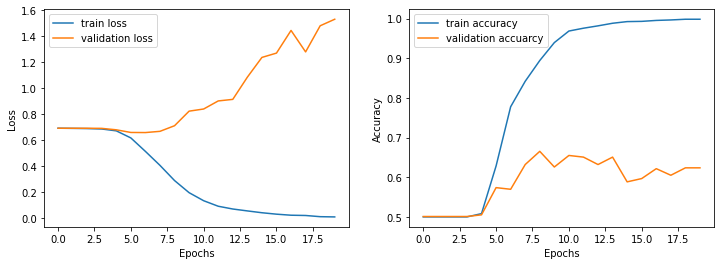

In [ ]:
# Evaluate on test
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot loss and accuracy
pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Text vectorizer + embedding + LSTM returning all hidden states + GlobalMaxPooling

In [ ]:
model_name = 'textvectorizer_embedding128_LSTM64_globalmaxpooling_sigmoid'

# Define architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# Train
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 12s 149ms/step - loss: 0.6921 - accuracy: 0.5030 - val_loss: 0.6891 - val_accuracy: 0.6154
Epoch 2/20
53/53 [==============================] - 6s 117ms/step - loss: 0.6868 - accuracy: 0.6790 - val_loss: 0.6820 - val_accuracy: 0.6611
Epoch 3/20
53/53 [==============================] - 7s 133ms/step - loss: 0.6336 - accuracy: 0.7396 - val_loss: 0.6766 - val_accuracy: 0.6071
Epoch 4/20
53/53 [==============================] - 6s 114ms/step - loss: 0.6231 - accuracy: 0.6748 - val_loss: 0.6826 - val_accuracy: 0.5551
Epoch 5/20
53/53 [==============================] - 6s 121ms/step - loss: 0.5424 - accuracy: 0.7776 - val_loss: 0.6306 - val_accuracy: 0.6466
Epoch 6/20
53/53 [==============================] - 6s 121ms/step - loss: 0.3871 - accuracy: 0.8698 - val_loss: 0.6126 - val_accuracy: 0.6653
Epoch 7/20
53/53 [==============================] - 6s 114ms/step - loss: 0.3242 - accuracy: 0.8633 - val_loss: 0.7059 - val_accuracy: 0.6341
Epoch

8/8 [==============================] - 2s 58ms/step - loss: 0.6363 - accuracy: 0.6680
Test Loss: 0.6362990736961365
Test Accuracy: 0.6680498123168945


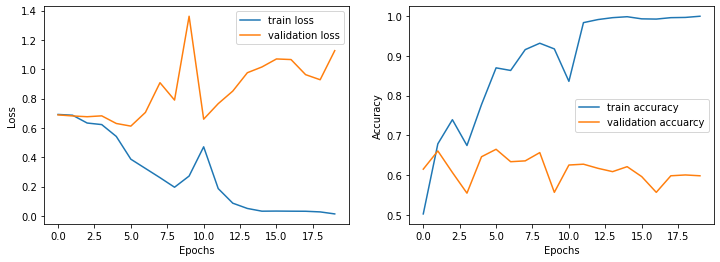

In [ ]:
# Evaluate on test
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot loss and accuracy
pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Simple dense networks

No RNNs are used, the structure is:

Embedding + GlobalMaxPooling + Dense layer(s)



## Model 1

In [ ]:
model_name = 'textvectorizer_embedding128_globalmaxpooling_dense50_dense10_sigmoid'

# Define architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# Train
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 6s 94ms/step - loss: 0.6934 - accuracy: 0.5155 - val_loss: 0.6930 - val_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 1s 27ms/step - loss: 0.6884 - accuracy: 0.5279 - val_loss: 0.6884 - val_accuracy: 0.5759
Epoch 3/20
53/53 [==============================] - 1s 27ms/step - loss: 0.6736 - accuracy: 0.6564 - val_loss: 0.6756 - val_accuracy: 0.6133
Epoch 4/20
53/53 [==============================] - 1s 28ms/step - loss: 0.6027 - accuracy: 0.7973 - val_loss: 0.6400 - val_accuracy: 0.6299
Epoch 5/20
53/53 [==============================] - 1s 27ms/step - loss: 0.4320 - accuracy: 0.8650 - val_loss: 0.6204 - val_accuracy: 0.6383
Epoch 6/20
53/53 [==============================] - 1s 22ms/step - loss: 0.2359 - accuracy: 0.9334 - val_loss: 0.6612 - val_accuracy: 0.6507
Epoch 7/20
53/53 [==============================] - 1s 22ms/step - loss: 0.1090 - accuracy: 0.9822 - val_loss: 0.7305 - val_accuracy: 0.6362
Epoch 8/20
53

8/8 [==============================] - 0s 18ms/step - loss: 0.6112 - accuracy: 0.6805
Test Loss: 0.611172616481781
Test Accuracy: 0.680497944355011


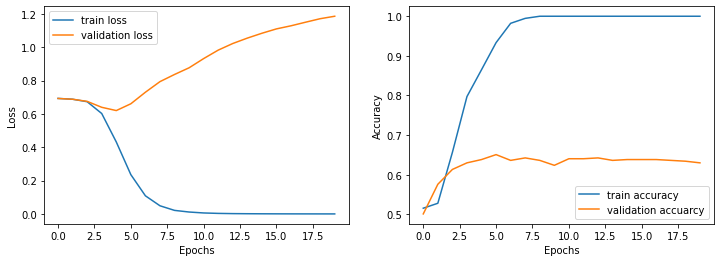

In [ ]:
# Evaluate on test
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot loss and accuracy
pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 2

In [ ]:
model_name = 'textvectorizer_embedding256_globalmaxpooling_dense128_dense64_sigmoid'

# Define architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Callbacks
mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

# Compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# Train
start_time = time.time()
history = model.fit(x = X_train, y = y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [mc])
print('Execution time: ', (time.time() - start_time) / 60, 'minutes')

Epoch 1/20
53/53 [==============================] - 3s 45ms/step - loss: 0.6938 - accuracy: 0.4893 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6900 - accuracy: 0.5333 - val_loss: 0.6882 - val_accuracy: 0.5177
Epoch 3/20
53/53 [==============================] - 2s 30ms/step - loss: 0.6547 - accuracy: 0.6647 - val_loss: 0.6522 - val_accuracy: 0.6154
Epoch 4/20
53/53 [==============================] - 2s 31ms/step - loss: 0.4513 - accuracy: 0.8216 - val_loss: 0.6191 - val_accuracy: 0.6674
Epoch 5/20
53/53 [==============================] - 1s 25ms/step - loss: 0.1965 - accuracy: 0.9352 - val_loss: 0.7083 - val_accuracy: 0.6570
Epoch 6/20
53/53 [==============================] - 1s 26ms/step - loss: 0.0625 - accuracy: 0.9887 - val_loss: 0.8036 - val_accuracy: 0.6549
Epoch 7/20
53/53 [==============================] - 1s 28ms/step - loss: 0.0184 - accuracy: 0.9994 - val_loss: 0.8802 - val_accuracy: 0.6403
Epoch 8/20
53

8/8 [==============================] - 0s 18ms/step - loss: 0.5846 - accuracy: 0.6763
Test Loss: 0.5845614671707153
Test Accuracy: 0.6763485670089722


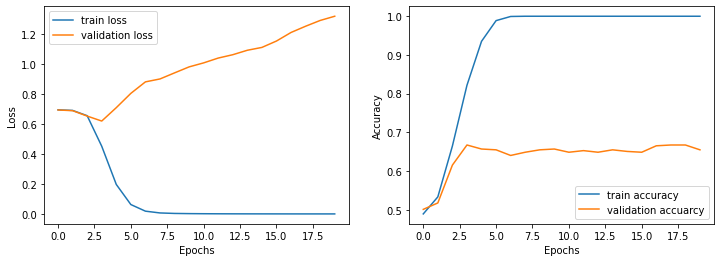

In [ ]:
# Evaluate on test
saved_model = tf.keras.models.load_model(path_to_models + model_name + '.h5')
loss, accuracy = saved_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot loss and accuracy
pickle.dump(history.history, open(path_to_models + model_name + ".pickle", "wb" ))
metrics_history = pickle.load(open(path_to_models + model_name + ".pickle", "rb" ))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics_history['loss'], label='train loss')
plt.plot(metrics_history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_history['accuracy'], label='train accuracy')
plt.plot(metrics_history['val_accuracy'], label='validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()